# Prestige Reinforcement Dynamics

This notebook provides a simple version of an asynchronous model of prestige-reinforcement in networked endorsement dynamics, as exemplified by the faculty hiring process. 

This notebook is intentionally designed to expose all calculations, so all functions etc. (other than SpringRank) are defined in here directly. 

Last updated: Feb. 3, 2020 by MK

In [ ]:
# Load the required packages
# import pandas as pd
import numpy as np
import SpringRank as sr
# from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

First, we'll define the function that takes in a matrix and returns the vector $\gamma$ of hiring probabilities. In our model instantiation, we compute this in two steps: 

1. $\phi:\mathbf{A} \mapsto s\in \mathbb{R}^n$ is the *SpringRank* functional that gives each node $i$ a rank $s_i$. 
2. Then, the hiring probability (probability that node $i$ is selected to be hired in the current timestep) is $\gamma_i = \frac{e^{\beta s_i}}{\sum_\ell e^{\beta s_\ell}}$, where $\beta \in \mathbb{R}$ is a model parameter. 

In [2]:
def compute_gamma(A, beta):
    
    # ignore some warning messages surfaced by SpringRank
    np.seterr(divide='ignore', invalid='ignore') 
    
    # compute springranks
    phi = sr.get_ranks(A)
    
    # exponentiate
    gamma = np.exp(beta * phi)
    
    # normalize
    gamma = gamma / gamma.sum()
    
    return(gamma)    

Next, we'll run the model dynamics. The `simulate` function implements both stochastic (real) and deterministic (approximate) versions of our dynamics. The `stochastic` method actually describes the model that we are working with: at each timestep $t$, a uniformly random department $j$ hires a candidate from department $i$ with probability proportional to $\gamma_i$. The hiring matrix is then updated by the equation $\mathbf{A}_{t+1} = \lambda \mathbf{A}_{t} + (1-\lambda)\mathbf{E}_{ij}$. In this expression, $\lambda \in [0,1]$ is a memory parameter. 

The `deterministic` method instead runs the dynamics $\hat{\mathbf{A}}_{t+1} = \lambda \hat{\mathbf{A}}_{t} + (1-\lambda)\mathbf{G}$, where $\mathbf{G}$ is the *expectation* of $\mathbf{E}_{ij}$ with respect to the probability distribution over $i$ and $j$. 

Other parameters of the `simulate` function include the number of departments $n$, prestige preference $\beta$, memory $\lambda$, number of rounds `n_rounds` over which to simulate; how frequently to update the SpringRanks (they can be slow for large numbers of departments), and an optional initial condition. 

This code is not at all optimized -- much faster versions may be possible. 

In [3]:

# construct the initial condition and container for trajectories
def initialize(n, n_rounds = 1, A0 = None):
    if A0 is None:
        A = np.ones((n, n)).astype(int)
    else:
        A = A0
    GAMMA = np.zeros((n_rounds, n))
    
    return(A, GAMMA)
    
# construct the increment to add to the current state. Either stochastic or deterministic. 
def increment(n, gamma, method = 'stochastic'):
    
    if method == 'stochastic':
        j = np.random.randint(n)           # uniformly random department gets to hire
        i = np.random.choice(n, p = gamma) # chooses from departments proportional to $\gamma$. 
        E = np.zeros((n,n))
        E[i,j] = 1
        return(E)
    
    elif method == 'deterministic': 
        G = np.tile(gamma, (n,1)).T        # G is the expectation of E above 
        return(G)
    
def simulate(n, beta, lam, n_rounds, method = 'stochastic', update_interval = 1, A0 = None):
    A, GAMMA = initialize(n, n_rounds, A0)
    
    for r in range(n_rounds):          
        if r % update_interval == 0:                    # update the springranks at this interval
            gamma = compute_gamma(A, beta)
            
        GAMMA[r,:] = gamma                              # record current gamma
        A = lam*A + (1-lam)*increment(n, gamma, method) # update A
        
    return(GAMMA)

Here's a simple example using the stochastic (real) simulation: 

In [ ]:
n        = 5
beta     = 3
lam      = .95
n_rounds = 1000
method   = 'deterministic'
update_interval = 1
A0       = np.ones((n,n)) 
A0[0,1] += 5
A0[1,2] += 5

GAMMA = simulate(n        = n, 
                 beta     = beta, 
                 lam      = lam, 
                 n_rounds = n_rounds, 
                 method   = method, 
                 update_interval = update_interval,
                 A0       = A0)

for i in range(n):
    plt.plot(GAMMA[:,i])

Here's a slightly more complex example in which we allow $\beta$ to vary, and study the behavior of both the stochastic and deterministic models. 

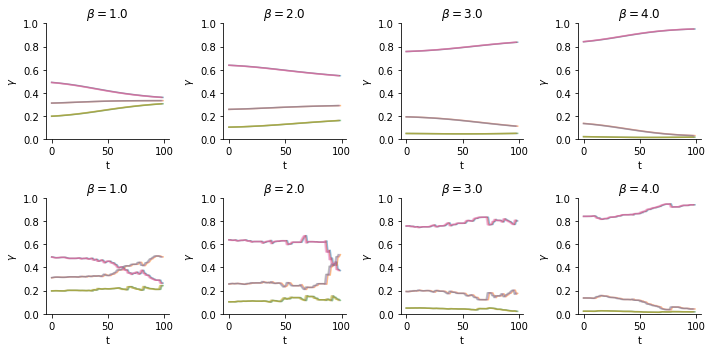

In [74]:
m_plots = 4 # this many columns of plots

betas = np.linspace(1, 4, m_plots) # evenly spaced values of $\beta$ between 1 and 3
n = 3                              # this many departments
lam = .95                          # memory param
n_rounds = 1000                    # simulation length

A0 = np.ones((n,n))                # asymmetric initial condition
A0[0,1] += 5
A0[1,2] += 5
    
methods = ['deterministic', 'stochastic'] # use both methods    

# create fig and axes
fig, axarr = plt.subplots(2,m_plots, figsize = (10, 5))

for k in range(2):
    for i in range(m_plots):

        # do the simulation
        v = simulate(n = n, 
                     beta = betas[i], 
                     lam = lam, 
                     n_rounds = n_rounds, 
                     update_interval = 1, 
                     A0 = A0, 
                     method = methods[k])
        
        # plot the results
        for j in range(n):
            axarr[k][i].plot(v[j:,], alpha = .5)
        
        # axis labels and aesthetics
        axarr[k][i].set(
                     ylim = (0,1),
                     title = r'$\beta = $' + str(betas[i]),
                     xlabel = 't',
                     ylabel = r'$\gamma$')

        axarr[k][i].spines['right'].set_visible(False)
        axarr[k][i].spines['top'].set_visible(False)
        
plt.tight_layout()

[0.05512607 0.05512608 0.05512608 0.05512608 0.05512608 0.72436962]
[0.43345031 0.43445122 0.03302436 0.03302446 0.03302531 0.03302435]
[0.05512647 0.05512598 0.05512598 0.05512598 0.72436962 0.05512598]


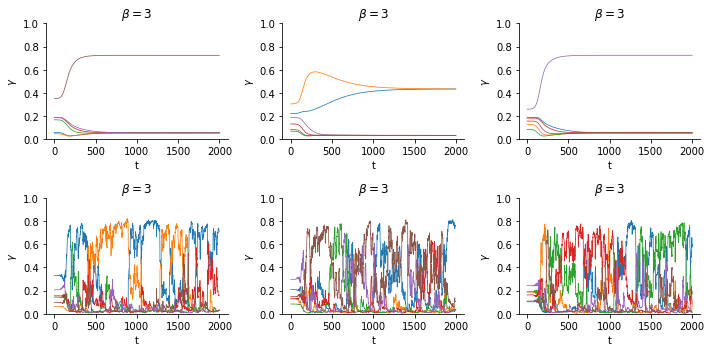

In [90]:
# version with random initialization
# for now, focus on a fixed value of beta

m_plots = 3 # this many columns of plots

betas = np.repeat(3, m_plots)     # evenly spaced values of $\beta$ between 1 and 3
ns = np.repeat(6, m_plots)        # this many departments
lam = .95                          # memory param
n_rounds = 2000                    # simulation length

# A0 = np.ones((n,n))                # asymmetric initial condition
# A0[0,1] += 5
# A0[1,2] += 5
    
methods = ['deterministic', 'stochastic'] # use both methods    

# create fig and axes
fig, axarr = plt.subplots(2, m_plots, figsize = (10, 5))
# colors     = plt.cm.viridis(np.linspace(0,255,n))

for k in range(2):
    for i in range(m_plots):
        
        n = ns[i]
        
        # random initialization
        A0 = np.random.randint(1, 100, size = (n,n))
        
        # do the simulation
        v = simulate(n = n, 
                     beta = betas[i], 
                     lam = lam, 
                     n_rounds = n_rounds, 
                     update_interval = 1, 
                     A0 = A0, 
                     method = methods[k])
        
        if k == 0:
            print(v[-1,])
        
        # plot the results
#         for j in range(n):
#             axarr[k][i].plot(v[j:,], alpha = 0.5)
        axarr[k][i].plot(v, alpha = 1, linewidth = 0.75)  # there was some redundancy
        
        # axis labels and aesthetics
        axarr[k][i].set(
                     ylim = (0,1),
                     title = r'$\beta = $' + str(betas[i]),
                     xlabel = 't',
                     ylabel = r'$\gamma$')

        axarr[k][i].spines['right'].set_visible(False)
        axarr[k][i].spines['top'].set_visible(False)
        
plt.tight_layout()
plt.savefig('temp_fig/test_mk_bias_random_max10_n_6_beta_3.pdf', bbox_inches='tight', dpi = 300)